In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000254.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_000322.jpg
/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000812.jpg
/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000737.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_002383.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_001654.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_001290.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_000646.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_002199.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_003448.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_003776.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_000311.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_003489.jpg
/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000468.jpg
/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000626.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_000971.j

## Import Stuff

In [2]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Locating individual images to create a dataframe of paths and labels

In [3]:
image_path=[]
labels=[]
for i in os.listdir('/kaggle/input/animal-faces/afhq'):
    for label in os.listdir(f'/kaggle/input/animal-faces/afhq/{i}'):
        for image in os.listdir(f'/kaggle/input/animal-faces/afhq/{i}/{label}'):
            image_path.append(f'/kaggle/input/animal-faces/afhq/{i}/{label}/{image}')
            labels.append(label)         

In [4]:
df=pd.DataFrame(zip(image_path, labels), columns=['Path', 'Label'])
df.sample(5, random_state=7)

,Path,Label
12388,/kaggle/input/animal-faces/afhq/train/cat/pixa...,cat
6596,/kaggle/input/animal-faces/afhq/train/wild/pix...,wild
5367,/kaggle/input/animal-faces/afhq/train/dog/pixa...,dog
13331,/kaggle/input/animal-faces/afhq/train/cat/pixa...,cat
14958,/kaggle/input/animal-faces/afhq/train/cat/pixa...,cat


## Split into Train Val and Test Dataframe using sampling as it preserves the dataframe
#### The Train Test Split converts it into list so again we have to create a class of dataset using torch.utils.Dataset that will be used to convert it back into a dataframe.

In [5]:
train_df=df.sample(frac=0.7, random_state=7)
test_df=df.copy()
test_df.drop(train_df.index, inplace=True)
val_df=test_df.sample(frac=0.5, random_state=7)
test_df.drop(val_df.index, inplace=True)
train_df.shape, val_df.shape, test_df.shape

((11291, 2), (2420, 2), (2419, 2))

In [6]:
le=LabelEncoder()
le.fit(train_df['Label'])


LabelEncoder()

In [7]:
transform=transforms.Compose([
    transforms.Resize([128,128]),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

In [8]:
class CustomImageDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.dataframe=dataframe
        self.transform=transform
        self.labels=torch.tensor(le.transform(self.dataframe['Label'])).to(device)
        
    def __len__(self):
        return self.dataframe.shape[0]
        
    def __getitem__(self, index):
        path=self.dataframe.iloc[index, 0]
        label=self.labels[index]

        image=Image.open(path).convert('RGB')
        
        if self.transform:
            image=self.transform(image).to(device)
        return image, label

In [9]:
train_dataset=CustomImageDataset(dataframe=train_df, transform=transform)
val_dataset=CustomImageDataset(dataframe=val_df, transform=transform)
test_dataset=CustomImageDataset(dataframe=test_df, transform=transform)

In [10]:
train_dataset.__getitem__(9)

(tensor([[[0.0627, 0.1137, 0.1373,  ..., 0.2235, 0.2627, 0.3294],
          [0.0667, 0.1333, 0.1373,  ..., 0.2471, 0.2980, 0.3451],
          [0.0863, 0.1725, 0.1647,  ..., 0.3059, 0.2941, 0.3137],
          ...,
          [0.3608, 0.2118, 0.1333,  ..., 0.3098, 0.3176, 0.3294],
          [0.3686, 0.3373, 0.1804,  ..., 0.3216, 0.3176, 0.3373],
          [0.3451, 0.4039, 0.2000,  ..., 0.3490, 0.3333, 0.3294]],
 
         [[0.1294, 0.1922, 0.2118,  ..., 0.1961, 0.2196, 0.2706],
          [0.1569, 0.2431, 0.2275,  ..., 0.2157, 0.2549, 0.2902],
          [0.1843, 0.2980, 0.2627,  ..., 0.2745, 0.2510, 0.2588],
          ...,
          [0.4784, 0.3137, 0.2588,  ..., 0.2078, 0.2157, 0.2275],
          [0.4667, 0.4314, 0.3059,  ..., 0.2196, 0.2157, 0.2353],
          [0.4510, 0.5098, 0.3412,  ..., 0.2471, 0.2314, 0.2275]],
 
         [[0.0510, 0.0902, 0.1176,  ..., 0.1529, 0.1647, 0.2078],
          [0.0588, 0.1294, 0.1333,  ..., 0.1765, 0.2000, 0.2235],
          [0.0706, 0.1765, 0.1725,  ...,

In [11]:
le.inverse_transform([0,1,2]) ## Above image at index 9 from train_dataset is an image of a Dog

array(['cat', 'dog', 'wild'], dtype=object)

In [12]:
train_DL=DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_DL=DataLoader(dataset=val_dataset, batch_size=16, shuffle=True)
test_DL=DataLoader(dataset=test_dataset, batch_size=16, shuffle=True)

In [13]:
class myCONVnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq=nn.Sequential( # 3x128x128
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3), # 16x126x126
            nn.MaxPool2d(2,2), # 16x63x63
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # 32x61x61
            nn.MaxPool2d(2,2,1), # 32x31x31
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3), # 16x29x29
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=16*29*29, out_features=512),
            nn.Linear(in_features=512, out_features=3)
        )
    def forward(self, x):
        return self.seq(x)

In [14]:
from torchsummary import summary

In [15]:
model=myCONVnet().to(device)

In [16]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             448
         MaxPool2d-2           [-1, 16, 63, 63]               0
              ReLU-3           [-1, 16, 63, 63]               0
            Conv2d-4           [-1, 32, 61, 61]           4,640
         MaxPool2d-5           [-1, 32, 31, 31]               0
              ReLU-6           [-1, 32, 31, 31]               0
            Conv2d-7           [-1, 16, 29, 29]           4,624
              ReLU-8           [-1, 16, 29, 29]               0
           Flatten-9                [-1, 13456]               0
           Linear-10                  [-1, 512]       6,889,984
           Linear-11                    [-1, 3]           1,539
Total params: 6,901,235
Trainable params: 6,901,235
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forw

In [17]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
from tqdm import tqdm

In [45]:
torch.manual_seed(7)
train_loss_pep=[]
val_loss_pep=[]
train_accuracy_pep=[]
val_accuracy_pep=[]
epochs=6
for epoch in range (epochs):
    train_batch_loss=[]
    val_batch_loss=[]
    train_batch_accuracy=[]
    val_batch_accuracy=[]
    model.train()
    for X, y in tqdm(train_DL):
        X, y=X.to(device), y.to(device)
        y_pred=model(X)
        loss=loss_fn(y_pred.squeeze(), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item())
        train_batch_accuracy.append(((y_pred.squeeze().argmax(dim=1)==y).sum()/X.shape[0]).item())
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(val_DL):
            X, y=X.to(device), y.to(device)
            y_pred=model(X)
            loss=loss_fn(y_pred.squeeze(), y)
            val_batch_loss.append(loss.item())
            val_batch_accuracy.append(((y_pred.squeeze().argmax(dim=1)==y).sum()/X.shape[0]).item())
    train_loss_pep.append(torch.tensor(train_batch_loss).mean().item())
    val_loss_pep.append(torch.tensor(val_batch_loss).mean().item())
    train_accuracy_pep.append(torch.tensor(train_batch_accuracy).mean().item())
    val_accuracy_pep.append(torch.tensor(val_batch_accuracy).mean().item())

100%|██████████| 152/152 [00:11<00:00, 13.73it/s]


In [47]:
import matplotlib.pyplot as plt

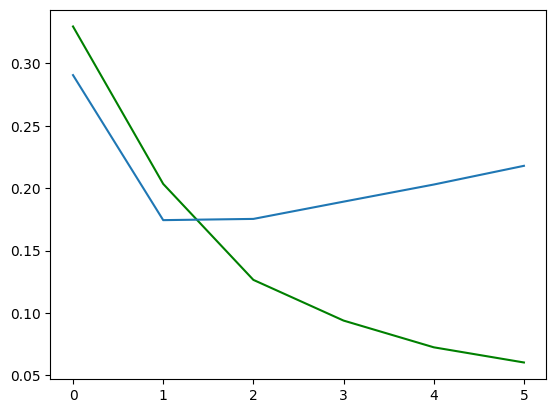

In [51]:
plt.plot([i for i in range(epochs)], train_loss_pep, color='green')
plt.plot([i for i in range(epochs)], val_loss_pep)

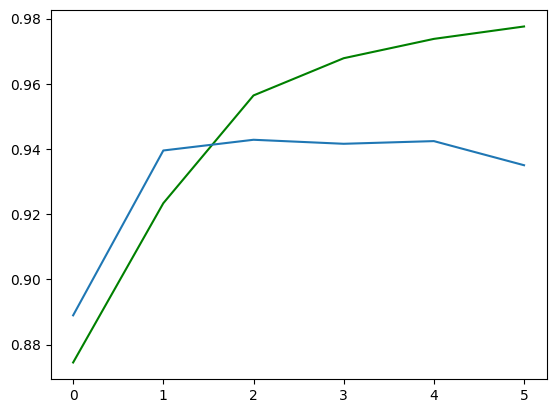

In [52]:
plt.plot([i for i in range(epochs)], train_accuracy_pep, color='green')
plt.plot([i for i in range(epochs)], val_accuracy_pep)

In [85]:
trues=0
tot=0
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_DL):
        X, y=X.to(device), y.to(device)
        y_pred=model(X).squeeze()
        trues+=(y_pred.argmax(dim=1)==y).sum()
        tot+=X.shape[0]
print(f'Accuracy: {((trues/tot)*100).item():.2f}%')

100%|██████████| 152/152 [00:11<00:00, 13.15it/s]

Accuracy: 93.72%


In [86]:
def predict(path):
    image=Image.open(path).convert('RGB')
    image=transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.inference_mode():
        y=model(image)
        print(f'The animal is: {le.inverse_transform(y.argmax(dim=1).cpu().numpy())[0]}')

In [87]:
predict('/kaggle/input/catcar/Screenshot 2025-05-08 113811.png')

The animal is: wild


In [88]:
predict('/kaggle/input/doggie/Screenshot 2025-05-08 164343.png')

The animal is: dog
